In [43]:
# Import internal libraries
import glob, json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [44]:
# Analyze reliability, bandwidth, energy
data = []
deadcols = np.genfromtxt("../settings/dead_columns.csv", delimiter=",")
refdir = "../lfsr"
for bpc in range(1, 3):
  refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
  for alias in glob.glob(f"../settings/opt/{bpc}bpc*.json"):
    alias = alias.split("/")[-1][:-5]
    print(alias)
    for mode in ["cb", "lfsr"]:
      for att in [1, 2, 4, 8] + list(range(16, 256, 32)) + [255]:
        # Real max attempts
        att = (att & 31) << (att >> 5)

        # Load and compute data
        try:
          diag = json.load(open(f"data/diag/diag_{mode}_{alias}_{att}.json"))
          dt = np.loadtxt(f"data/dt/dt_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
          continue
        try:
          ivdd = np.loadtxt(f"data/power/vdd_{mode}_power_{alias}_{att}.csv", delimiter=',')
          ivddio = np.loadtxt(f"data/power/vddio_{mode}_power_{alias}_{att}.csv", delimiter=',')
        except OSError:
          ivdd = np.array([0])
          ivddio = np.array([0])

        # Load data into confmat
        try:
            confmat = np.loadtxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", delimiter=',')
        except OSError:
            try:
                postread = np.loadtxt(f"data/postread/postread_{mode}_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                confmat = np.zeros(shape=(2**bpc, 2**bpc))
                bad = []
                for i in range(65535):
                    for j in range(48):
                        if (j in deadcols):
                            continue
                        if mode == "cb":
                          confmat[(i + j) % (2**bpc)][postread[i][j]] += 1
                          if (i + j) % (2**bpc) != postread[i][j]:
                             bad.append([i,j,(i + j) % (2**bpc),postread[i][j]])
                        elif mode == "lfsr":
                          confmat[refvec[i][j]][postread[i][j]] += 1
                        else:
                          raise Exception("Unknown mode")
                confmat = confmat.astype(int)
                np.savetxt(f"data/confmat/confmat_{mode}_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                np.savetxt(f"data/confmat/bad_{mode}_{alias}_{att}.csv", bad, fmt='%s', delimiter=',')
                print(confmat)
            except OSError:
                continue

        # Compute metrics
        power_tot = (ivdd * 0.9 + ivddio * 3.3).mean()
        dt2 = diag["cycles"] * 10e-9
        bw = confmat.sum() * bpc / dt2 # bits per second
        energy_per_bit = power_tot / bw
        edp = energy_per_bit / bw

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = 1 - confmat.trace() / confmat.sum()
        
        # Compose dataframe
        d = {"alias": f"{alias}_{mode}", "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
        d.update(diag)
        data.append(d)
data = pd.DataFrame(data)
data

1bpc_pba_8146
1bpc_bwa_17823
1bpc_bwa_0
1bpc_bwa_14927
1bpc_bwa_19048
1bpc_bwa_13144
1bpc_bwa_10186
1bpc_bwa_18459
1bpc_bwa_16903
1bpc_bwa_16031
2bpc_pba_18449
2bpc_pba_18449_c
2bpc_bwa_19036
2bpc_pba_18451_g
[[650933  19523     16   1261]
 [ 24920 639690   4070   3054]
 [  1061   3751 664178   2745]
 [    71     31   1852 669779]]
2bpc_pba_18451_c
2bpc_pba_18451_f
2bpc_pba_18449_b
2bpc_bwa_19532
2bpc_pba_18451_d
2bpc_bwa_19031
2bpc_pba_18449_e
2bpc_pba_18451_e
2bpc_pba_18451_b
2bpc_pba_18449_d
2bpc_pba_18451
2bpc_pba_19007


,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,1bpc_bwa_0_cb,3968,1,0.8222808837890625,0.822253,0.008308,2.481821e-09,7.414017e-16,3.347472e+06,0.000381,...,0.019522,65536,556,3689735,721054,2639139,82225344,21771976,10862134,3990330
1,2bpc_pba_18449_cb,3968,2,24.64510941505432,24.644628,0.008272,3.703138e-08,1.657828e-13,2.233728e+05,0.017643,...,0.168331,65536,15358,107887670,7846942,97929048,2464462781,199171034,33637218,143338357
2,2bpc_pba_18449_c_cb,3968,2,39.608213663101196,39.607327,0.007631,5.490747e-08,3.950521e-13,1.389879e+05,0.026555,...,0.262501,65536,18831,107513215,8065457,97300073,3960732670,169810219,33470521,113832398
3,2bpc_pba_18451_g_cb,3968,2,18.16714119911194,18.166800,0.007560,2.555667e-08,8.639638e-14,2.958072e+05,0.023207,...,0.178380,65536,5007,32421717,7488095,23192629,1816680010,74752534,30623500,26239673
4,2bpc_pba_18451_c_cb,3968,2,42.095335960388184,42.094597,0.007451,5.836823e-08,4.572100e-13,1.276618e+05,0.023644,...,0.206397,65536,15127,74455778,8106390,64434982,4209459669,120833591,32828267,67869051
5,2bpc_pba_18451_f_cb,3968,2,18.06119394302368,18.060762,0.007618,2.560415e-08,8.605166e-14,2.975439e+05,0.018997,...,0.166232,65536,4971,32236170,7490651,23002983,1806076169,74567089,30618404,26043381
6,2bpc_pba_18449_b_cb,3968,2,23.025874137878418,23.025378,0.008232,3.443293e-08,1.440218e-13,2.390814e+05,0.018183,...,0.203859,65536,16363,100856545,8058281,90661007,2302537750,169623350,33970941,113210803
7,2bpc_pba_18451_d_cb,3968,2,18.962366342544556,18.961886,0.007385,2.605793e-08,9.194632e-14,2.834038e+05,0.019351,...,0.168524,65536,5097,33868406,8031891,23931504,1896188611,79024562,32369625,27080160
8,2bpc_pba_18449_e_cb,3968,2,20.814979791641235,20.814360,0.007029,2.722511e-08,1.054497e-13,2.581809e+05,0.012656,...,0.140958,65536,4132,37233545,9007499,25956068,2081436028,89553091,33815931,32404915
9,2bpc_pba_18451_e_cb,3968,2,18.497541904449463,18.497056,0.007595,2.614282e-08,8.998453e-14,2.905257e+05,0.019211,...,0.167111,65536,4991,33028929,7770007,23429845,1849705618,76845139,31498967,26552290


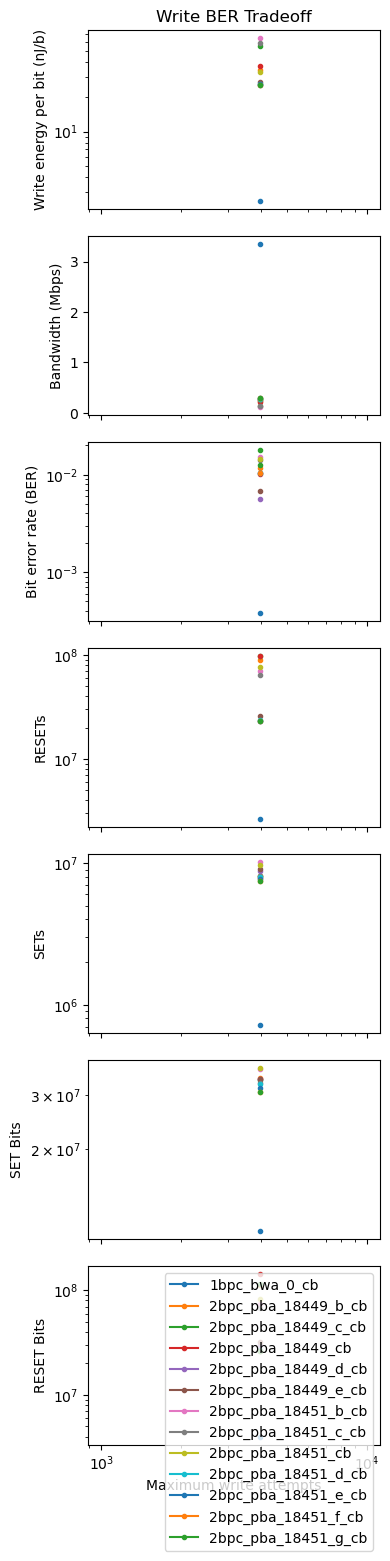

In [45]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(7, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
  plt.xlabel("Maximum write attempts")
  plt.xscale("log")
  axs[0].set_title(f"Write BER Tradeoff")
  axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
  axs[0].set_yscale("log")
  axs[0].set_ylabel("Write energy per bit (nJ/b)")
  axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
  axs[1].set_ylabel("Bandwidth (Mbps)")
  axs[2].plot(d["att"], d["ber"], ".-", label=alias)
  axs[2].set_yscale("log")
  axs[2].set_ylabel("Bit error rate (BER)")
  axs[3].plot(d["att"], d["resets"], ".-", label=alias)
  axs[3].set_yscale("log")
  axs[3].set_ylabel("RESETs")
  axs[4].plot(d["att"], d["sets"], ".-", label=alias)
  axs[4].set_yscale("log")
  axs[4].set_ylabel("SETs")
  axs[5].plot(d["att"], d["set_bits"], ".-", label=alias)
  axs[5].set_yscale("log")
  axs[5].set_ylabel("SET Bits")
  axs[6].plot(d["att"], d["reset_bits"], ".-", label=alias)
  axs[6].set_yscale("log")
  axs[6].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.subplots_adjust(hspace=0.15)
plt.show()